In [1]:
import os
import pymeshlab
from time import sleep
import shlex, subprocess
from io import BytesIO
import pandas as pd
import numpy as np
import seaborn as sns

In [2]:

### Global Constants ###
reeb_graph = "/home/ubuntu/reeb_graph"
models_dir = "/home/ubuntu/fa3ds/backend/assemble/assemble_utils/models"
wrl_header = \
"""
#VRML V2.0 utf8
WorldInfo {
    info [
        "This file was created by the GICL Sat2Vrml program",
        "http://gicl.mcs.drexel.edu/",
        "Drexel University",
        "Released under the GNU GPL",
        "Copyright (C) 2001 Daniel Lapadat"
    ]
    title "GICL Sat2Vrml"
}
Viewpoint {
    fieldOfView 0.785398
    position 50 50 300
    orientation 0 0 1 0
    description "Front"
    jump TRUE
}
Viewpoint {
    fieldOfView 0.785398
    position 50 50 -200
    orientation 1 0 0 3.141593
    description "Back"
    jump TRUE
}
Viewpoint {
    fieldOfView 0.785398
    position 300 50 50
    orientation 0 1 0 1.570796
    description "Right Side"
    jump TRUE
}
Viewpoint {
    fieldOfView 0.785398
    position -200 50 50
    orientation 0 1 0 -1.570796
    description "Left Side"
    jump TRUE
}
Viewpoint {
    fieldOfView 0.785398
    position 50 300 50
    orientation 1 0 0 -1.570796
    description "Top"
    jump TRUE
}
Viewpoint {
    fieldOfView 0.785398
    position 50 -200 50
    orientation 1 0 0 1.570796
    description "Bottom"
    jump TRUE
}
Viewpoint {
    fieldOfView 0.785398
    position 200 200 200
    orientation 1 -1 0 -1.047198
    description "Diagonal Top"
    jump TRUE
}
Viewpoint {
    fieldOfView 0.785398
    position -100 -100 -100
    orientation 1 -1 0 2.094395
    description "Diagonal Bottom"
    jump TRUE
}
NavigationInfo {
    avatarSize [0.25, 1.6, 0.75]
    headlight TRUE
    speed 1.0
    type ["EXAMINE", "ANY"]
    visibilityLimit 0.0
}
Transform {
        children [
            Shape {
                geometry IndexedFaceSet {
                    coord Coordinate {
                        point [
"""
wrl_end_point = \
"""
                    ] #end of point
                } #end of Coordinate
                coordIndex [
"""
wrl_footer = \
"""
                ] #end of coordIndex
            } #end of geometry
            appearance Appearance {
                material Material {
                    diffuseColor 0.7 0.7 0.7
                    emissiveColor 0.05 0.05 0.05
                    specularColor 1.0 1.0 1.0
                    ambientIntensity 0.2
                    shininess 0.2
                    transparency 0.0
                } #end of material
            } #end of appearance
        } #end of Shape
    ] #end of children
}
"""

def similarity(mesh_set, arg1 = 4000, mu = 0.0005, arg2 = 128, arg3 = 0.5):
    """
    Computes the similarities between a set of meshes

    Inputs
        :mesh_set: <pymeshlab.MeshSet> a set of meshes to be evaluated for similarity
        :arg1: <float>
        :mu: <float>
        :arg2: <float>
        :arg3: <float>

    Outputs
        :returns: <dict> mapping mesh -> most similar other mesh
    """
    model_paths = []
    for i, mesh in enumerate(mesh_set):
        faces, vertices = mesh.face_matrix(), mesh.vertex_matrix()
        model_path = f"{models_dir}/model_{i}.wrl"

        model_paths.append(model_path)
        _save_as_wrl(faces, vertices, model_path)

    command_0 = "echo " + "\n".join(model_path for model_path in model_paths)
    process_0 = _exec(command_0, keep_output = True)

    command_1 = f"xargs  java -cp \"{reeb_graph}/src/\" -Xmx1024m ExtractReebGraph {arg1} {mu} {arg2}"
    process_1 = _exec(command_1, stdin = process_0.stdout)

    command_0 = "echo " + "\n".join(model_path for model_path in model_paths)
    process_0 = _exec(command_0, keep_output = True)

    command_2 = f"xargs  java -cp \"{reeb_graph}/src/\" -Xmx1024m CompareReebGraph {arg1} {mu} {arg2} {arg3}" 
    process_2 = _exec(command_2, stdin = process_0.stdout)
    
    out = process_2.stdout.decode('utf8').strip().split("\n")
    for line in out:
        model_1, model_2, sim = line.split(",")
        name_1, _ = os.path.splitext(model_1)
        name_2, _ = os.path.splitext(model_2)
        name_1, name_2 = name_1.split("/")[-1], name_2.split("/")[-1]

        print(f"[out] >> {name_1} ~ {name_2} = {float(sim):.3f}")
        
        with open("./similarity_results_component_2.csv", "a") as fi:
            fi.write(f"{name_1},{name_2},{float(sim):.3f}\n")
            
    
    _exec(f"rm -rf {models_dir}")
    _exec(f"mkdir {models_dir}")

    for i, mesh in enumerate(mesh_set):
        ms.set_current_mesh(i)
        ms.save_current_mesh(f"{models_dir}/model_{i}.obj")

### Helper Functions ###
def _exec(command: str, wait: int = None, stdin = None, keep_output = False) -> subprocess:
    """
    Executes a command using a subprocess and returns the execution subprocess

    Inputs
        :command: <str> command to execute 
        :wait: <int> amount of time to wait for command to execute
    
    Outputs
        :subprocess: <subprocess> a sub-process that runs the executed command
    """
    # print(f"[cmd] >> {command}")
    command = shlex.split(command)
    if not keep_output: process = subprocess.run(command, stdout=subprocess.PIPE, stdin=stdin)
    else: process = subprocess.Popen(command, stdout=subprocess.PIPE, stdin=stdin)
        
    if wait is not None: sleep(wait)
    return process

def _save_as_wrl(faces, vertices, path):
    """
    Export given list of Mesh objects to a VRML file.

    Inputs
        :faces: <np.ndarray> of size (f, 3) for f faces
        :vertices: <np.ndarray> of size (v, 3) for v vertices
        :path: path to store vrml to 
    """
    # print("Converting to wrl ...")
    with open(path, 'w') as wrl:
        # write the standard VRML header
        wrl.write(wrl_header)

        #write coordinates (x, y, z) for each vertex
        wrl.write("\t\t\t\t\t\t" + "\n\t\t\t\t\t\t".join(f"{v[0]:.3f} {v[1]:.3f} {v[2]:.3f}," for v in vertices))
        wrl.write(wrl_end_point)
        
        # write vertex indexes for each face
        wrl.write("\t\t\t\t\t\t" + "\n\t\t\t\t\t\t".join(f"{f[0]}, {f[1]}, {f[2]}, -1," for f in faces))
        wrl.write(wrl_footer) 
    # print("--- Done ---")

In [5]:
mesh_path_1 = "/home/ubuntu/fa3ds/backend/assemble/Experiments/model_20/5_segmentation/segment_1.0/segment_1.0.obj"
mesh_path_2 = "/home/ubuntu/fa3ds/backend/assemble/Experiments/model_20/5_segmentation/segment_2.0/segment_2.0.obj"

In [48]:
mesh_list = []
for root, dirs, files in os.walk('/home/ubuntu/fa3ds/backend/assemble/Experiments/model_22'):
    for name in files:
        file_path = os.path.join(root, name)
        if file_path.endswith(".obj"):
            mesh_list.append(file_path)
print(mesh_list)

# for root, dirs, files in os.walk('/home/ubuntu/fa3ds/backend/assemble/Experiments/model_20'):
#     for name in files:
#         file_path = os.path.join(root, name)
#         if file_path.endswith(".obj"):
#             mesh_list.append(file_path)
# print(mesh_list)

['/home/ubuntu/fa3ds/backend/assemble/Experiments/model_22/5_segmentation/segment_4.0/segment_4.0.obj', '/home/ubuntu/fa3ds/backend/assemble/Experiments/model_22/5_segmentation/segment_1.0/segment_1.0.obj', '/home/ubuntu/fa3ds/backend/assemble/Experiments/model_22/5_segmentation/segment_3.0/segment_3.0.obj', '/home/ubuntu/fa3ds/backend/assemble/Experiments/model_22/5_segmentation/segment_0.0/segment_0.0.obj', '/home/ubuntu/fa3ds/backend/assemble/Experiments/model_22/5_segmentation/segment_2.0/segment_2.0.obj']


In [49]:
ms = pymeshlab.MeshSet()
for mesh_path in mesh_list:
    print(mesh_path)
    ms.load_new_mesh(mesh_path)

similarity(ms)

/home/ubuntu/fa3ds/backend/assemble/Experiments/model_22/5_segmentation/segment_4.0/segment_4.0.obj
/home/ubuntu/fa3ds/backend/assemble/Experiments/model_22/5_segmentation/segment_1.0/segment_1.0.obj
/home/ubuntu/fa3ds/backend/assemble/Experiments/model_22/5_segmentation/segment_3.0/segment_3.0.obj
/home/ubuntu/fa3ds/backend/assemble/Experiments/model_22/5_segmentation/segment_0.0/segment_0.0.obj
/home/ubuntu/fa3ds/backend/assemble/Experiments/model_22/5_segmentation/segment_2.0/segment_2.0.obj
[out] >> model_0 ~ model_0 = 1.000
[out] >> model_0 ~ model_1 = 0.740
[out] >> model_0 ~ model_2 = 0.517
[out] >> model_0 ~ model_3 = 0.879
[out] >> model_0 ~ model_4 = 0.202
[out] >> model_1 ~ model_0 = 0.740
[out] >> model_1 ~ model_1 = 1.000
[out] >> model_1 ~ model_2 = 0.571
[out] >> model_1 ~ model_3 = 0.779
[out] >> model_1 ~ model_4 = 0.271
[out] >> model_2 ~ model_0 = 0.517
[out] >> model_2 ~ model_1 = 0.571
[out] >> model_2 ~ model_2 = 1.000
[out] >> model_2 ~ model_3 = 0.589
[out] >> m

In [50]:
csv_file = pd.read_csv("./similarity_results_component_2.csv")
array = np.zeros((5,5),dtype='float64')
for index, element in csv_file.iterrows():
    model_1,model_2,score = element
    array[int(model_1[-1]), int(model_2[-1])] = float(score)

In [51]:
array

array([[1.   , 0.74 , 0.517, 0.879, 0.202],
       [0.74 , 1.   , 0.571, 0.779, 0.271],
       [0.517, 0.571, 1.   , 0.589, 0.186],
       [0.879, 0.779, 0.589, 1.   , 0.284],
       [0.202, 0.271, 0.186, 0.284, 1.   ]])

<AxesSubplot:>

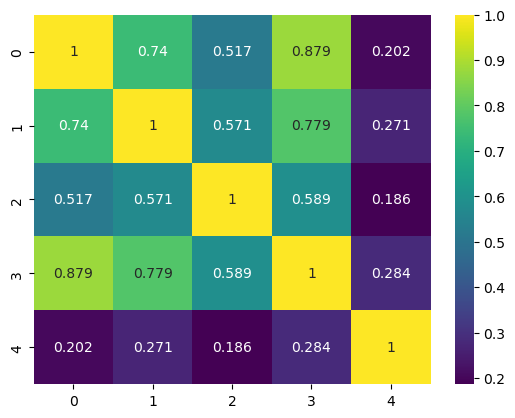

In [52]:
sns.heatmap(array, annot=True, fmt="g", cmap='viridis')

In [27]:
import csv

with open('/home/ubuntu/fa3ds/backend/assemble/Experiments/similarity_results_component_1.csv') as f:
    csv_reader = csv.reader(f, delimiter=",")
    first_row = True
    for row in csv_reader:
        if first_row:
            continue
        print(row)

['Model_1', 'Model_2', 'Score']
['model_0', 'model_1', '0.156']
['model_0', 'model_2', '0.500']
['model_0', 'model_3', '0.782']
['model_0', 'model_4', '0.623']
['model_0', 'model_5', '0.647']
['model_0', 'model_6', '0.136']
['model_0', 'model_7', '0.774']
['model_1', 'model_0', '0.156']
['model_1', 'model_1', '1.000']
['model_1', 'model_2', '0.140']
['model_1', 'model_3', '0.152']
['model_1', 'model_4', '0.226']
['model_1', 'model_5', '0.179']
['model_1', 'model_6', '0.744']
['model_1', 'model_7', '0.165']
['model_2', 'model_0', '0.500']
['model_2', 'model_1', '0.140']
['model_2', 'model_2', '1.000']
['model_2', 'model_3', '0.475']
['model_2', 'model_4', '0.560']
['model_2', 'model_5', '0.495']
['model_2', 'model_6', '0.130']
['model_2', 'model_7', '0.482']
['model_3', 'model_0', '0.782']
['model_3', 'model_1', '0.152']
['model_3', 'model_2', '0.475']
['model_3', 'model_3', '1.000']
['model_3', 'model_4', '0.647']
['model_3', 'model_5', '0.729']
['model_3', 'model_6', '0.135']
['model_